# DANDI:001628 NWB tutorial

This tutorial demonstrates how to access an NWB file from [DANDI:001268](https://dandiarchive.org/dandiset/001628/draft) for the study detailed in [_"Microinvasive Probes for Monitoring Electrical and Chemical Neural Activity in Nonhuman Primates"_](https://www.biorxiv.org/content/10.1101/2025.01.30.635139v1.full.pdf).

This dataset contains in vivo FSCV and EPhys measurements from micro-invasive probes chronically implanted in the striatum of task-performing rhesus monkeys.


### Import Required Libraries

In [1]:
# Core data manipulation and analysis
import os

import h5py

# Visualization
import matplotlib.pyplot as plt
import numpy as np
import remfile

# NWB and DANDI access
from dandi.dandiapi import DandiAPIClient
from matplotlib.ticker import ScalarFormatter
from pynwb import NWBHDF5IO

# Configure matplotlib
plt.rcParams['font.size'] = 10

# Streaming an NWB file

This section demonstrates how to stream an NWB file from the DANDI Archive using `remfile` and `pynwb`.

To access an embargoed dataset on DANDI, you will need to obtain a DANDI API key by creating an account on the [DANDI Archive](https://dandiarchive.org/) and copying the API key from your account.

See the DANDI documentation for more details:
https://docs.dandiarchive.org/user-guide-sharing/uploading-data/#storing-access-credentials

In [5]:
# Load session data from DANDI
dandiset_id = "001628"
subject_id = "Monkey-T"
session_id = "09262024"

filepath = f"sub-{subject_id}/sub-{subject_id}_ses-{session_id}_behavior+ecephys.nwb"

# This is only needed if you are accessing an embargoed dataset
# 1) Sets env var for the notebook kernel and subprocesses
# os.environ["DANDI_API_KEY"] = "myapikeystring"

token = os.environ.get("DANDI_API_KEY")
with DandiAPIClient(token=token) as client:
    asset = client.get_dandiset(dandiset_id, 'draft').get_asset_by_path(filepath)
    s3_url = asset.get_content_url(follow_redirects=1, strip_query=False)

# Create a disk cache to store downloaded data (optional)
cache_dirname = '/tmp/remfile_cache'
disk_cache = remfile.DiskCache(cache_dirname)

# open the file
rem_file = remfile.File(s3_url, disk_cache=disk_cache)
h5py_file = h5py.File(rem_file, "r")
io = NWBHDF5IO(file=h5py_file)
# read the NWB file
nwbfile = io.read()


## Read NWB file from local path

Alternative: You can also read the NWB file from a local path using `pynwb.read_nwb()`.

In [2]:
# Read NWB file from local path
from pynwb import read_nwb

# Example session with EPhys data
nwbfile_path = "/Users/weian/data/Schwerdt/nwbfiles/microinvasiveProbes_manuscript/sub-Monkey-T_ses-09262024.nwb"
nwbfile = read_nwb(nwbfile_path)

### Session start time

All timestamps in the NWB file are represented as relative times (in seconds) from the session start time.
The session start time is set to the time when the **Neuralynx** system began recording, which is
`2024-09-26 09:01:38.000000` in this example session:

In [3]:
print(nwbfile.session_start_time)

2024-09-26 09:01:38-04:00


# Subject

This section demonstrates how to access the [Subject](https://pynwb.readthedocs.io/en/stable/pynwb.file.html#pynwb.file.Subject) field in an NWBFile.

The [Subject](https://pynwb.readthedocs.io/en/stable/pynwb.file.html#pynwb.file.Subject) field can be accessed as `nwbfile.subject`.

In [7]:
nwbfile.subject

subject pynwb.file.Subject at 0x6048658976
Fields:
  age: P11Y
  age__reference: birth
  description: Two adult female rhesus monkeys were used for in vivo validation of the s-µIP device, with chronic implants targeting the striatum for simultaneous FSCV and EPhys recordings during behavioral tasks.
  sex: F
  species: Macaca mulatta
  subject_id: Monkey T

# Access Recording

This section demonstrates how to access the raw `ElectricalSeries` data.

`NWB` organizes data into different groups depending on the type of data. Groups can be thought of as folders within the file. Here are some of the groups within an NWBFile and the types of data they are intended to store:

- `acquisition`: raw, acquired data that should never change
- `processing`: processed data, typically the results of preprocessing algorithms and could change

## Raw ElectricalSeries

The raw ElectricalSeries data is stored in an [pynwb.ecephys.ElectricalSeries](https://pynwb.readthedocs.io/en/stable/pynwb.ecephys.html#pynwb.ecephys.ElectricalSeries) object which is added to `nwbfile.acquisition`. The data can be accessed as `nwbfile.acquisition["electrical_series"]`.

The data in `ElectricalSeries` is stored as a two dimensional array: the first dimension is time, the second dimension represents electrodes/channels.

In [4]:
electrical_series = nwbfile.acquisition["electrical_series"]

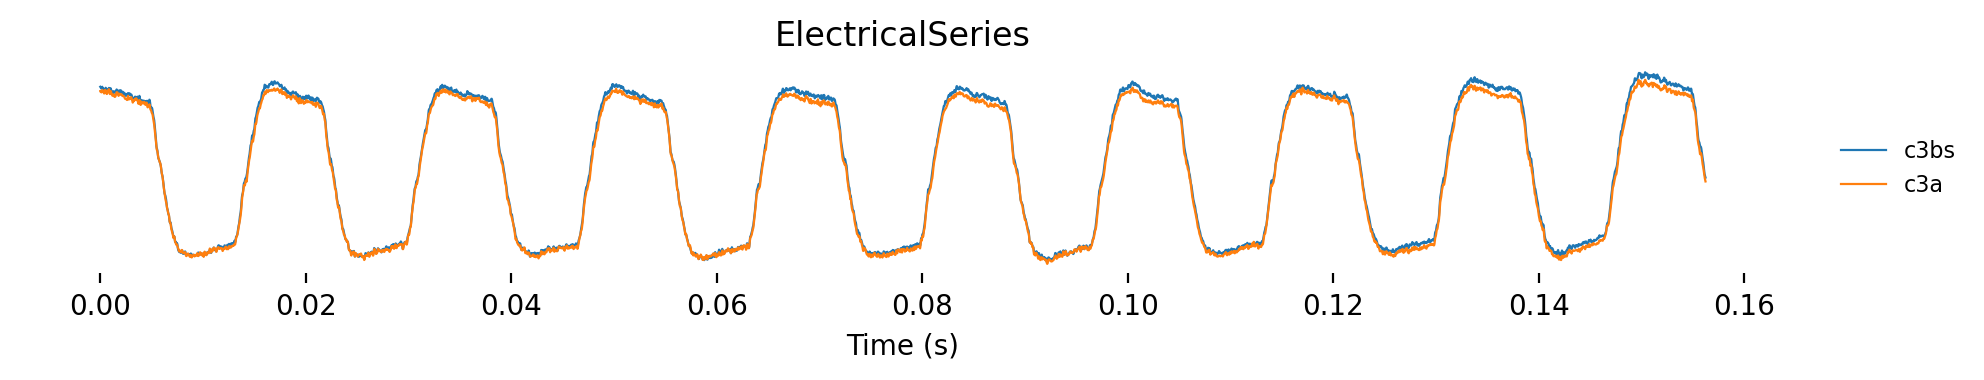

In [5]:
# Extract data
rate = electrical_series.rate
data = electrical_series.data[:5000, :10]
timestamps = electrical_series.get_timestamps()[:5000]
channel_names = electrical_series.electrodes["location"][:]

# Create plot
fig, ax = plt.subplots(figsize=(10, 2), dpi=200)

# Plot each channel
for i, ch_name in enumerate(channel_names):
    ax.plot(timestamps, data[:, i], label=ch_name, linewidth=0.8)

# Style
ax.set_title('ElectricalSeries')
ax.set_xlabel('Time (s)')
ax.set_frame_on(False)
ax.tick_params(left=False, labelleft=False)
ax.legend(frameon=False, loc='upper right', ncol=2, fontsize=8)

formatter = ScalarFormatter(useOffset=False)
formatter.set_scientific(False)
ax.xaxis.set_major_formatter(formatter)

ax.legend(
    frameon=False,
    loc='center left',         # anchor to the left side
    bbox_to_anchor=(1.02, 0.5),# move outside the axes
    ncol=1,
    fontsize=8
)

plt.tight_layout()
plt.show()


The electrodes table describe the electrodes that generated this data. Extracellular electrodes are stored in an "electrodes" table, which is a [DynamicTable](https://hdmf.readthedocs.io/en/stable/hdmf.common.table.html#hdmf.common.table.DynamicTable) and can be can be converted to a pandas DataFrame for convenient analysis using `nwbfile.electrodes.to_dataframe()`.

In [10]:
nwbfile.electrodes.to_dataframe()

,location,group,group_name,channel_name,DspLowCutFilterType,DSPLowCutFilterEnabled,DspHighCutFrequency,recording_closed,DspFilterDelay_µs,NumADChannels,...,input_inverted,recording_opened,ADMaxValue,FileType,DspLowCutNumTaps,DspDelayCompensation,RecordSize,DSPHighCutFilterEnabled,DspHighCutNumTaps,DspHighCutFilterType
id,,,,,,,,,,,,,,,,,,,,,
0,c3bs,ElectrodeGroup pynwb.ecephys.ElectrodeGroup at...,ElectrodeGroup,CSC37,DCO,True,8000,2024-09-26 16:02:14,3984,1,...,False,2024-09-26 09:01:38,32767,NCS,0,True,1044,True,256,FIR
1,c3a,ElectrodeGroup pynwb.ecephys.ElectrodeGroup at...,ElectrodeGroup,CSC38,DCO,True,8000,2024-09-26 16:02:14,3984,1,...,False,2024-09-26 09:01:38,32767,NCS,0,True,1044,True,256,FIR


## Filtered ElectricalSeries


The processed ecephys data is stored in "processing/ecephys" which can be accessed as `nwbfile.processing["ecephys"]`.
Within this processing module we can access the container of filtered traces as `nwbfile.processing["ecephys"]["FilteredEphys"]` which can hold multiple processed `ElectricalSeries` objects.

In [21]:
nwbfile.processing["ecephys"]

Data type,float64
Shape,"(19247100, 1)"
Array size,146.84 MiB
Chunk shape,"(1250000, 1)"
Compression,gzip
Compression opts,4
Compression ratio,1.0476786712670774
Data type,float64
Shape,"(19247100,)"
Array size,146.84 MiB
Chunk shape,"(1250000,)"


In [6]:
processed_ecephys = nwbfile.processing["ecephys"]["FilteredEphys"]

differential_lfp_series = processed_ecephys["differential_lfp_series"]
differential_lfp_series

Data type,float64
Shape,"(19247100, 1)"
Array size,146.84 MiB
Chunk shape,"(1250000, 1)"
Compression,gzip
Compression opts,4
Compression ratio,1.0476786712670774
Data type,float64
Shape,"(19247100,)"
Array size,146.84 MiB
Chunk shape,"(1250000,)"


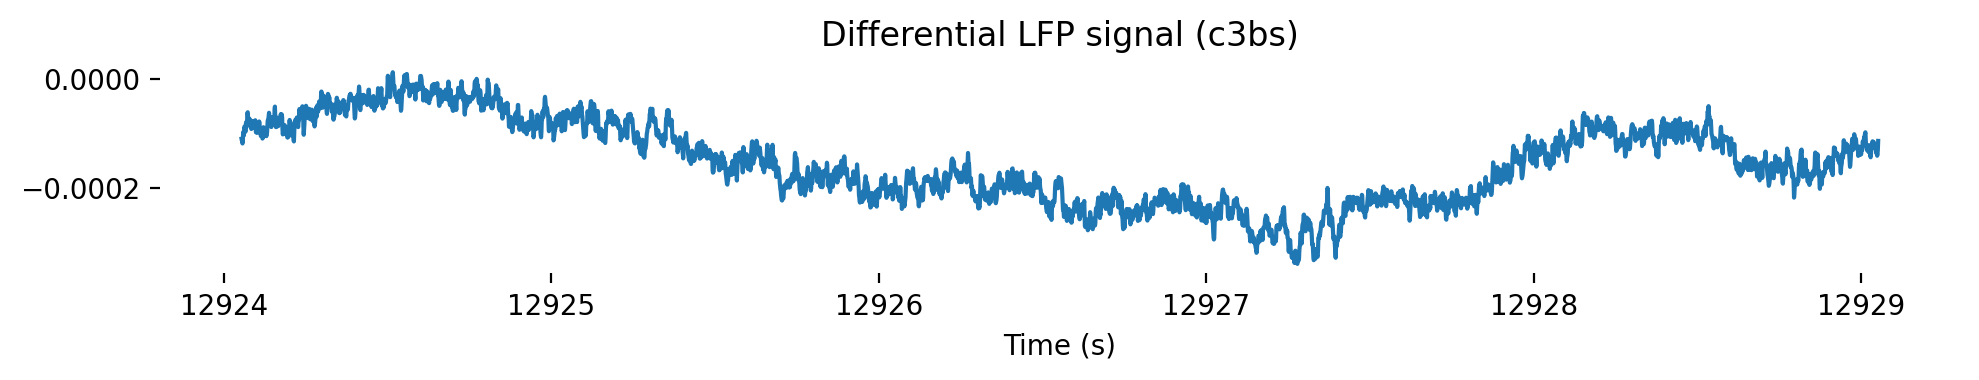

In [7]:
fig, ax = plt.subplots(figsize=(10, 2), dpi=200)

t = np.array(differential_lfp_series.timestamps)
d = np.array(differential_lfp_series.data)
ax.plot(t[5000:10000], d[5000:10000, 0])

ax.set_title('Differential LFP signal (c3bs)')
ax.set_frame_on(False)
ax.set_xlabel('Time (s)')

formatter = ScalarFormatter(useOffset=False)
formatter.set_scientific(False)
ax.xaxis.set_major_formatter(formatter)

plt.tight_layout()
plt.show()


## Raw Eye Tracking

Raw eye-tracking signals recorded by the Neuralynx system are imported and stored in the NWB acquisition as an `EyeTracking`
container containing one `SpatialSeries` that stores the continuous gaze position time series (x, y).


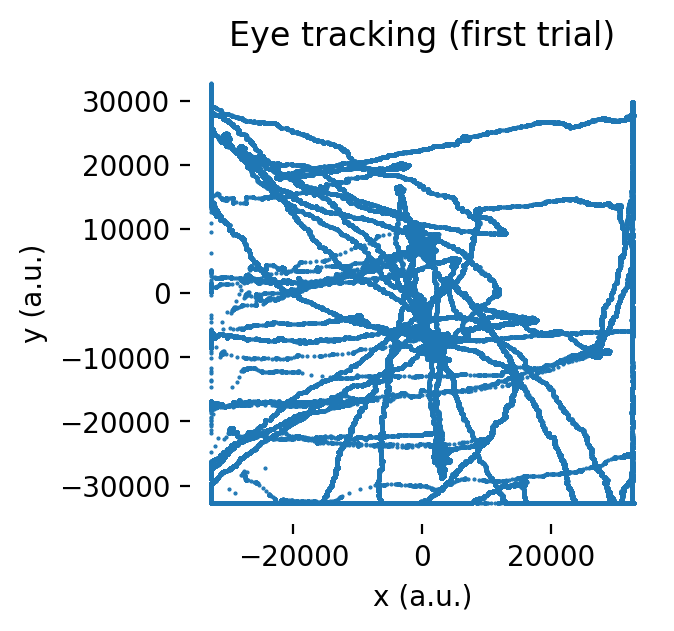

In [8]:
eye_tracking = nwbfile.acquisition["EyeTracking"]
eye_tracking_series = eye_tracking["eye_tracking_series"]

data = np.array(eye_tracking_series.data)
rate = float(eye_tracking_series.rate)

trial_start = nwbfile.trials["start_time"][0]
trial_stop = nwbfile.trials["stop_time"][0]

plt.figure(figsize=(3,3), dpi=200)

plt.plot(data[int(rate*trial_start):int(rate*trial_stop), 0], data[int(rate*trial_start):int(rate*trial_stop),1], '.', markersize=1)
plt.xlabel('x (a.u.)')
plt.ylabel('y (a.u.)')
plt.title('Eye tracking (first trial)')
plt.gca().set_frame_on(False)
plt.show()

# Trials

The trials can be accessed as `nwbfile.trials` and can be converted to pandas DataFrame as `nwbfile.trials.to_dataframe()`

In [46]:
nwbfile.trials.to_dataframe()

,start_time,stop_time,midpoint_time,tags,timeseries
id,,,,,
0,12919.053511,12979.053511,12949.053511,[initial cue display],"[(0, 60001, differential_lfp_series pynwb.ecep..."
1,12933.598360,12993.598360,12963.598360,[initial cue display],"[(14545, 60001, differential_lfp_series pynwb...."
2,12946.610890,13006.610890,12976.610890,[initial cue display],"[(27558, 60001, differential_lfp_series pynwb...."
3,12960.222840,13020.222840,12990.222840,[initial cue display],"[(41170, 60001, differential_lfp_series pynwb...."
4,12973.518878,13033.518878,13003.518878,[initial cue display],"[(54466, 60002, differential_lfp_series pynwb...."
...,...,...,...,...,...
1496,32062.748030,32122.748030,32092.748030,[initial cue display],"[(19144443, 60003, differential_lfp_series pyn..."
1497,32076.476282,32136.476282,32106.476282,[initial cue display],"[(19158172, 60003, differential_lfp_series pyn..."
1498,32090.221984,32150.221984,32120.221984,[initial cue display],"[(19171919, 60002, differential_lfp_series pyn..."


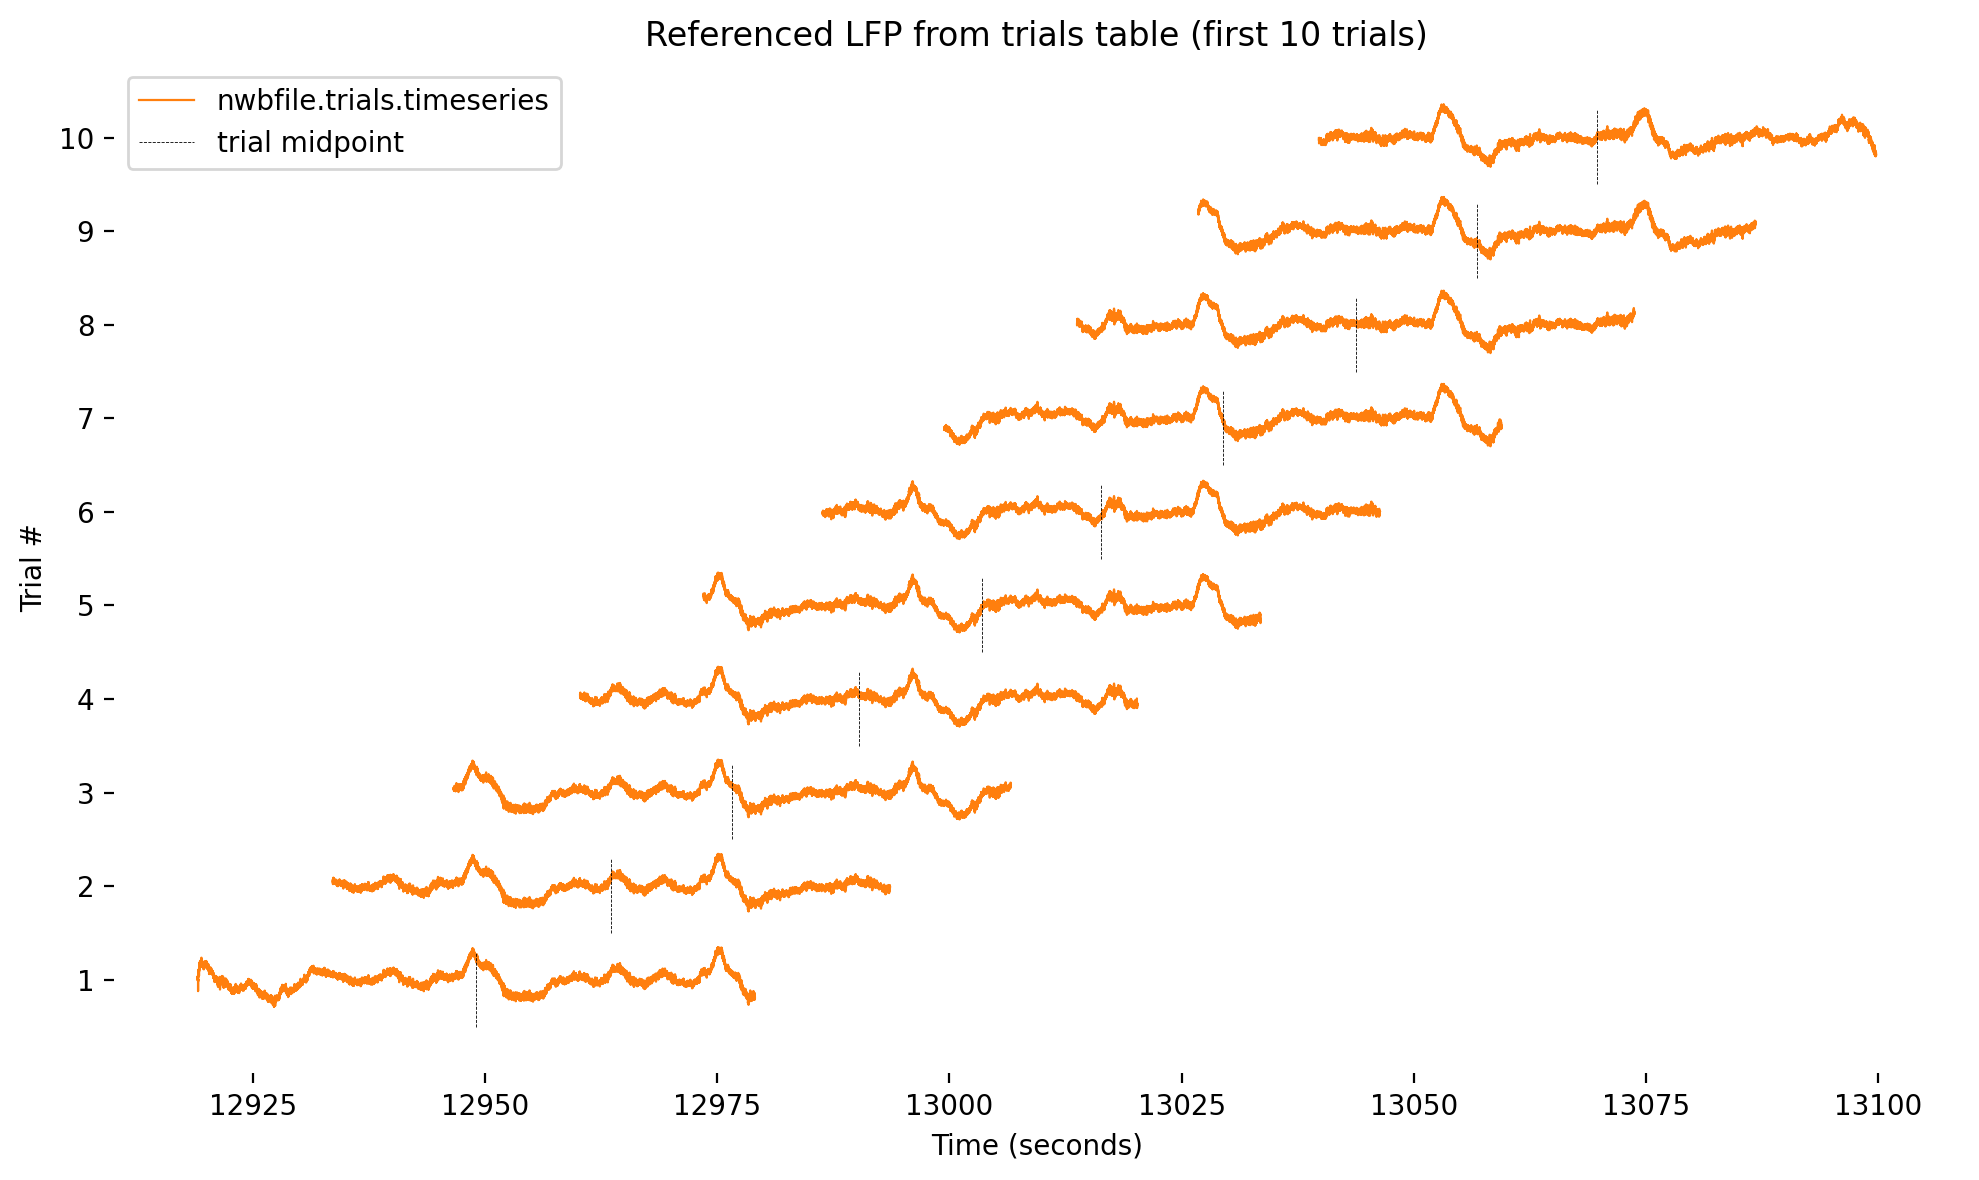

In [9]:
trials = nwbfile.trials
timeseries = trials.timeseries

# Get a single example TimeSeriesReference from the trials table
example_tsr = nwbfile.trials["timeseries"][0][0]

# Get the data values from the timeseries. This is a shorthand for:
# _ = example_tsr.timeseries.data[example_tsr.idx_start: (example_tsr.idx_start + example_tsr.count)]
y = example_tsr.data

data_per_trial = [nwbfile.trials["timeseries"][trial][0].data for trial in range(10)]
timestamps_per_trial = [nwbfile.trials["timeseries"][trial][0].timestamps for trial in range(10)]

plt.figure(figsize=(10, 6), dpi=200)
n = 10
# determine a reasonable scaling so traces don't overlap: base on peak-to-peak across plotted trials
p2p_list = [np.nanmax(trial) - np.nanmin(trial) for trial in data_per_trial[:10]]
max_p2p = float(np.nanmax(p2p_list)) if p2p_list else 1.0
spacing = max_p2p * 1.2 if max_p2p > 0 else 1.0

midpoints = trials["midpoint_time"][:]
for i, trial_data in enumerate(data_per_trial[:10]):
    # center each trace on its trial number and scale to fit within spacing
    centered = trial_data - np.nanmean(trial_data)
    y = centered / spacing * 0.8 + (i + 1)
    plt.plot(timestamps_per_trial[i], y, color="C1", linewidth=0.8, label="nwbfile.trials.timeseries" if i == 0 else None)
    plt.vlines(x=midpoints[i], ymin=i + 0.5, ymax=i + 1.3, color="black", linewidth=.3, linestyle="--", label="trial midpoint" if i == 0 else None)

plt.xlabel("Time (seconds)")
plt.ylabel("Trial #")
plt.yticks(np.arange(1, n + 1))
plt.title(f"Referenced LFP from trials table (first {n} trials)")
plt.ylim(0.0, n + 0.8)
#plt.grid(axis="x", linestyle=":", alpha=0.6)
plt.tight_layout() # for legend
plt.legend(loc="upper left")
plt.gca().set_frame_on(False)
plt.show()

# Events

The events are added to processing module named "events" which can be accessed as `nwbfile.processing["events"]`.

The table can be accessed as `events["events_table"][:]`, where the `"event_times"` are populated from `NlxEventTS`, the description of the event contains the code from `NlxEventTTL`.


In [10]:
events = nwbfile.processing["events"]
# Get the events table
events_table = events["events_table"][:]

events_table

,event_times,label,event_description
id,,,
0,"[12949.053511, 12963.59836, 12976.61089, 12949...",trial start,The event times for code '128'.
1,"[12949.053761, 12963.598641, 12976.611171, 129...",right condition,The event times for code '118'.
2,"[12949.420043, 12963.914922, 12976.943856, 129...",central cue fixation started,The event times for code '50'.
3,"[12950.852627, 12965.348111, 12978.376789, 129...",value object start,The event times for code '23'.
4,"[12951.219158, 12965.714643, 12978.726664, 129...",value cue fixation started,The event times for code '51'.
5,"[12954.651394, 12969.146574, 12954.651394, 129...",feedback,The event times for code '21'.
6,"[12955.641539, 12970.133233, 12955.641539, 129...",small reward,The event times for code '100'.
7,"[12955.78432, 12970.279764, 12955.78432, 12970...",reward delivery end,The event times for code '105'.
8,"[12961.53236, 12974.544911, 12961.53236, 12974...",end trial,The event times for code '18'.


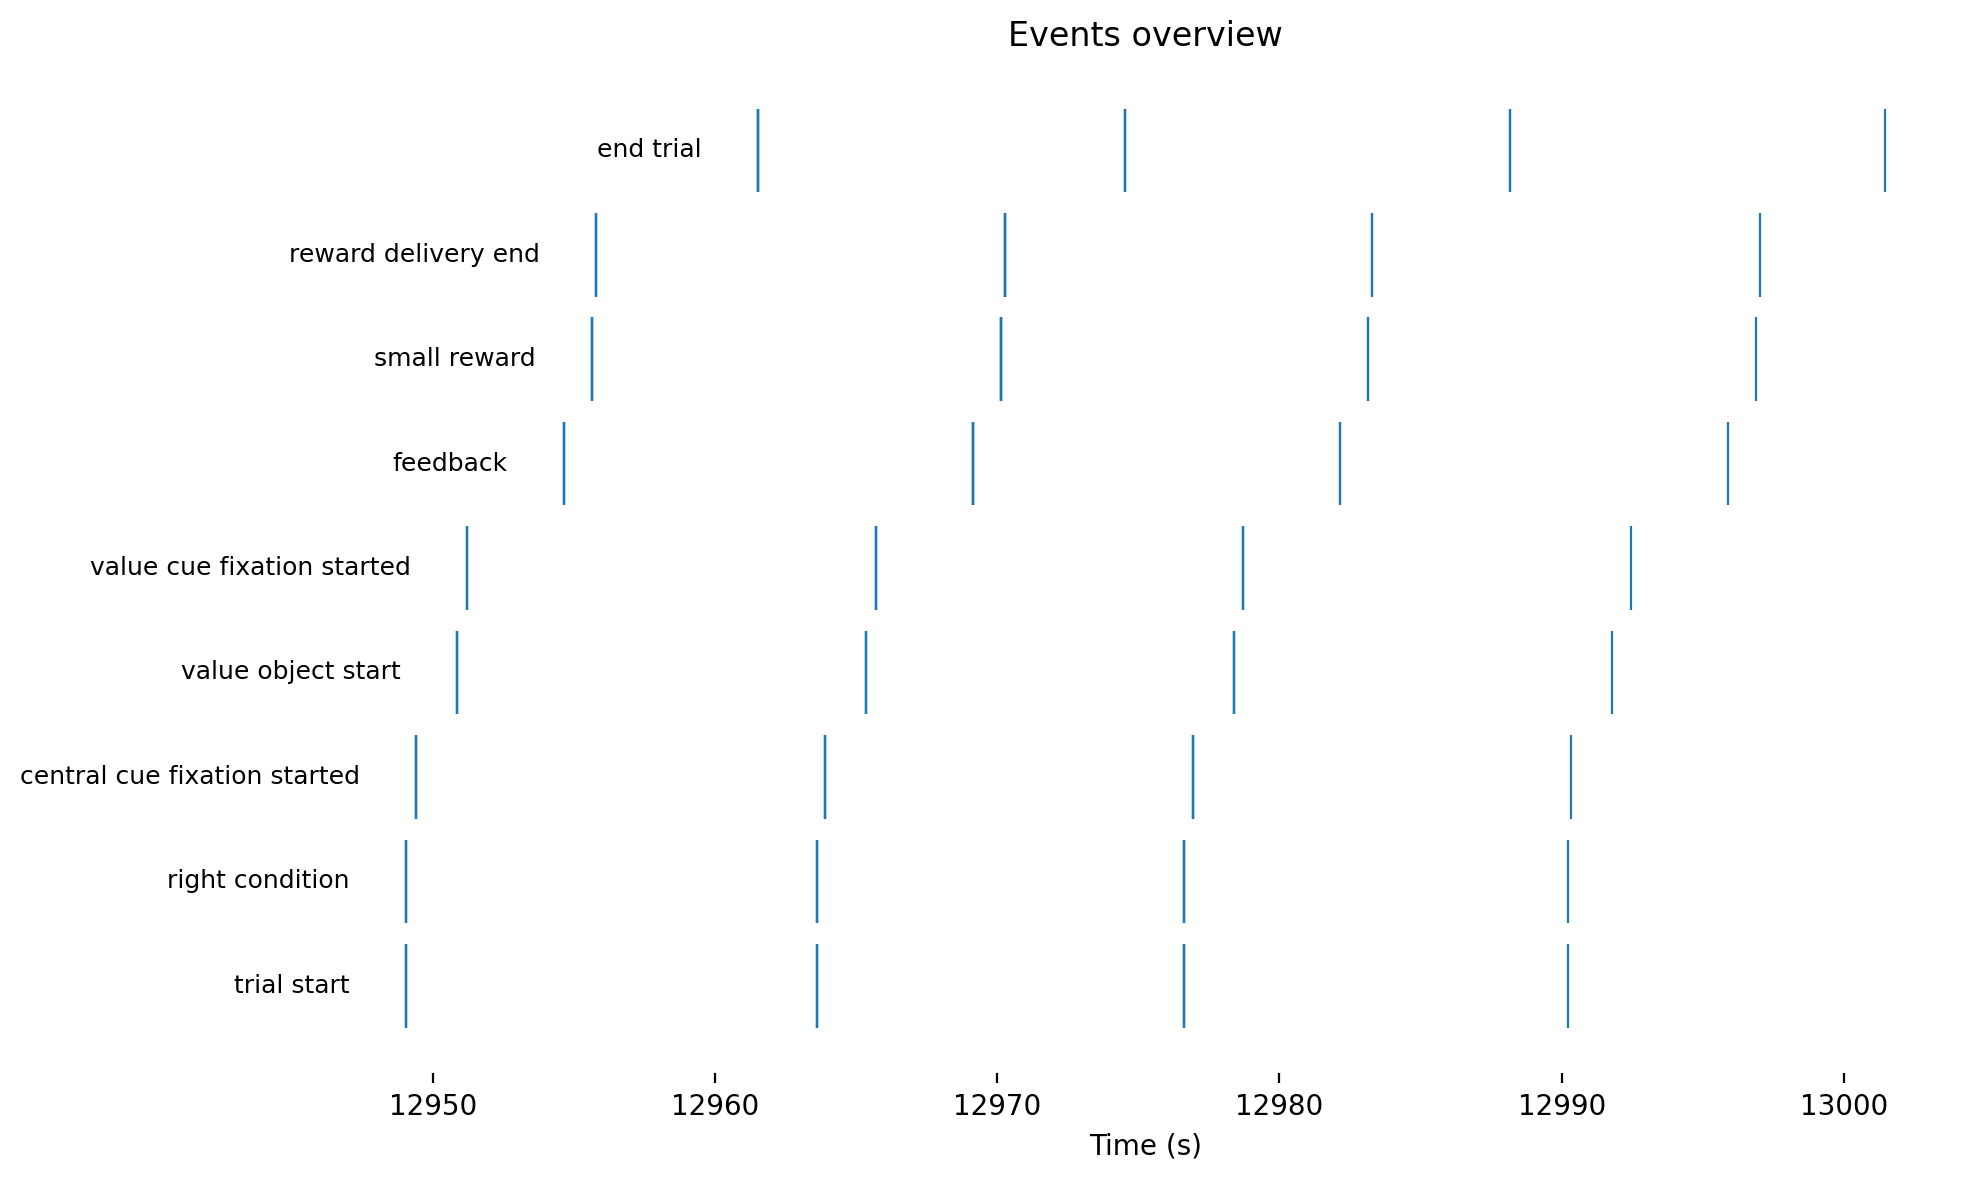

In [11]:
plt.figure(figsize=(10, 6), dpi=200)

for i, row in events_table.head(9).iterrows():
    label = row["label"]
    times = np.array(row["event_times"])[:10]
    plt.vlines(times, i + 0.6, i + 1.4, lw=0.8)
    plt.text(times.min() - 2, i + 1, label, va="center", ha="right", fontsize=9)

plt.xlabel("Time (s)")
plt.ylabel("Event label")
plt.title("Events overview")
plt.yticks([])
plt.tight_layout()
plt.gca().set_frame_on(False)   # remove the frame
plt.ylabel("")
plt.show()


In [14]:
# close the file
io.close()
h5py_file.close()
rem_file.close()